# Basics of Monte Carlo simulations with Numpy


# Importance of Monte Carlo Methods for Quants

Monte Carlo methods are a cornerstone of quantitative finance. They use random sampling to simulate complex systems and estimate numerical results, especially when analytical solutions are impractical or impossible.

## Why Monte Carlo Methods Matter

- **Handle Complexity**: Ideal for modeling systems with many uncertain variables or nonlinear dependencies.
- **Risk Estimation**: Crucial for calculating Value at Risk (VaR), Expected Shortfall, and other risk metrics.
- **Pricing Derivatives**: Used to price exotic options and structured products where closed-form solutions don’t exist.
- **Scenario Analysis**: Simulate thousands of market scenarios to assess portfolio performance under stress.
- **Flexibility**: Can be adapted to various asset classes, models, and market conditions.

## How Different Quant Roles Use Monte Carlo Methods

| Quant Role                 | Monte Carlo Applications                                                                 |
|---------------------------|-------------------------------------------------------------------------------------------|
| **Quantitative Researcher** | Develops and tests pricing models using Monte Carlo simulations for derivatives and structured products. |
| **Risk Quant**              | Uses Monte Carlo to simulate portfolio losses and compute risk metrics like VaR and Expected Shortfall. |
| **Trading Quant**           | Applies Monte Carlo to optimize trading strategies under uncertainty and simulate execution costs. |
| **Portfolio Quant**         | Models asset allocation and rebalancing strategies across thousands of simulated market paths. |
| **Model Validation Quant**  | Verifies the accuracy and robustness of pricing and risk models by comparing Monte Carlo outputs to benchmarks. |
| **Data Scientist / ML Quant** | Uses Monte Carlo techniques in probabilistic modeling, Bayesian inference, and uncertainty quantification. |




In [1]:
import numpy as np
# plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.size'] = 12
print('NumPy version:', np.__version__)

NumPy version: 2.3.3


## 1. Pseudorandom number generation (Linear Congruential Generator)


A **linear congruential generator (LCG)** is one of the oldest and simplest pseudorandom number generators.


It generates a sequence using the recurrence relation:


$$ X_{n+1} = (aX_n + c) \mod m $$


Parameters (a, c, m) define the generator’s characteristics, with $a<m$ and $c<m$. $X_0$ represents the seed. Our output sequence is then given by $\{\frac{X_0}{m},\frac{X_1}{m}\}$ which follows a $U[0,1)$.

Let's implement the algorithm and verify it:



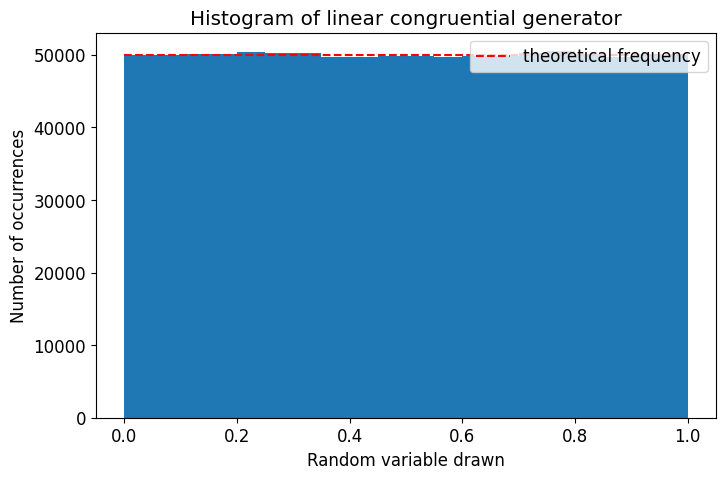

In [9]:
def lcg(a, c, m, seed, n):
    """Generate n pseudorandom numbers in [0,1) using an LCG."""
    assert(a<m)
    assert(c<m)
    x = seed
    seq = []
    for _ in range(n):
        x = (a * x + c) % m
        seq.append(x / m)
    return np.array(seq)


# Parameters (example: Numerical Recipes)
a = 1664525
c = 1013904223
m = 2**32
seed = 12345

samples=1000000
u = lcg(a, c, m, seed, samples)
n_bins=20
plt.hist(u,bins=n_bins)
plt.title("Histogram of linear congruential generator")
plt.ylabel("Number of occurrences")
plt.xlabel("Random variable drawn")
plt.hlines(samples/n_bins,0,1,color='r',linestyle="--",label="theoretical frequency")
plt.legend()
plt.show()

As you can see we roughly obtain a uniform [0,1) distribution.

**Note:** Modern generators are more sophisticated, but keep in mind that the sequence is deterministic

## 2. Random Walk and Brownian motion

A Brownian motion $W_t$ for $t\geq 0$ is a stochastic process defined by the following 4 poperties:

1. $W_0=0$
2. $W_t-W_s\sim \mathcal{N}(0,t-s)$ for $0\leq s\leq t$
3. $W_t$ is almost surely continuos
4. $W_t$ has independent increments i.e. $W_t-W_s$ and $W_u-W_v$ are independent for $0\leq v\leq u\leq s \leq t$

**Note** In particular, it also holds that $\text{Corr}(W_t-W_s,W_u-W_v)=0$

### Discrete time simulation 
We will focus on discrete time simulation of Brownian motion with the following approach:

1. Fix a time grid with $N$-steps $\{t_1,....,t_N\}$ such that and $t_{i}=\frac{i-1}{N-1}$ with  $t_1=0$ and $t_N=T$
2. We have the relation $W_{t_{i+1}}=W_{t_i}+(W_{t_{i+1}}-W_{t_{i}})=W_{t_i}+Z_i$ where $Z_i\sim\mathcal{N}(0,\frac{T}{N-1})$ i.i.d

#### A naive simulation approach:

In [16]:
# We can easily simulate using the recursive relation and numpy's random number generation
np.random.seed(0)
N=252
W=np.zeros(N)
T=2.0
time=np.linspace(0,T,N)
for i in range(1,N):
    W[i]=W[i-1]+np.random.normal(0,np.sqrt(T/(N-1)))
    

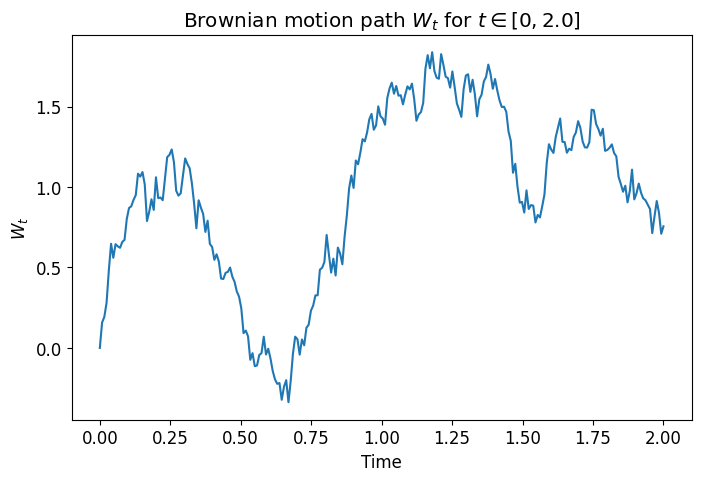

In [21]:
plt.plot(time,W)
plt.title(f"Brownian motion path $W_t$ for $t\\in [0,{T}]$")
plt.xlabel("Time")
plt.ylabel("$W_t$")
plt.show()

### A vectorized elegant approach:

Note that we have $W_{t_i}=\displaystyle\sum_{u=0}^{i-1}Z_u,\quad$ where $Z_i\sim\mathcal{N}(0,\frac{T}{N-1})$ i.i.d and $Z_0=0$

This is a perfect setup for np.cumsum

In [22]:
np.random.seed(0)
W=np.zeros(N)
W[1:]=np.cumsum(np.random.normal(0,np.sqrt(T/(N-1)),size=N-1))

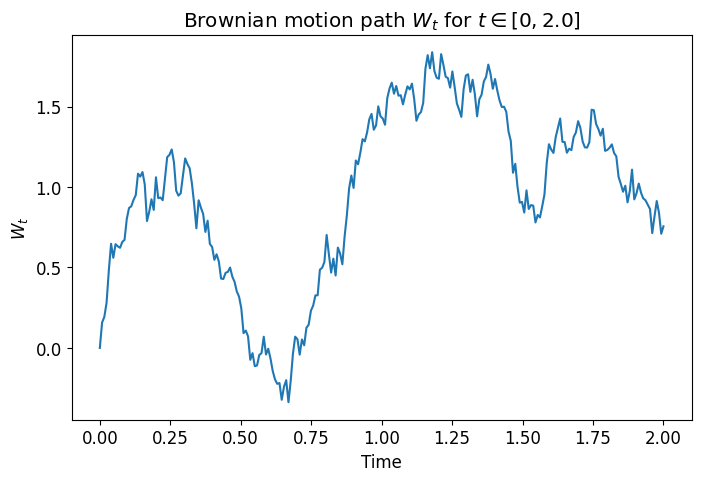

In [23]:
plt.plot(time,W)
plt.title(f"Brownian motion path $W_t$ for $t\\in [0,{T}]$")
plt.xlabel("Time")
plt.ylabel("$W_t$")
plt.show()

**Note:** We got precisely the same path. You can check and convince yourselves that the vectorized version is much more efficient speedwise

### Simulating multiple paths with vectorization

We may extend the previous approach to simulate multiple paths and generate a matrix 
$$(W^1_t,....,W^M_t)= \begin{pmatrix}
W^1_{t_1} \quad \cdots \quad  W^M_{t_1} \\
\vdots \quad  \ddots \quad \vdots \\
W^1_{t_N} \quad \cdots \quad W^M_{t_N} 
\end{pmatrix}  $$

Note that we still have $W^j_{t_i}=\displaystyle\sum_{u=0}^{i-1}Z^j_u,\quad$ where $Z^j_i\sim\mathcal{N}(0,\frac{T}{N-1})$ i.i.d and $Z^j_0=0$

So we can still easily apply  np.cumsum, with the axis keyword

In [27]:
np.random.seed(0)
N=252
M=10
W=np.zeros((N,M))
T=2.0
time=np.linspace(0,T,N)
W[1:,:]=np.cumsum(np.random.normal(0,np.sqrt(T/(N-1)),size=(N-1,M)),axis=0)

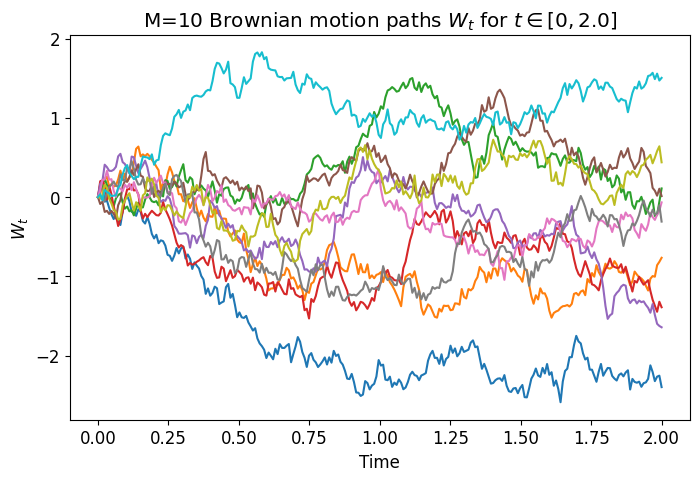

In [28]:
plt.plot(time,W)
plt.title(f"M={M} Brownian motion paths $W_t$ for $t\\in [0,{T}]$")
plt.xlabel("Time")
plt.ylabel("$W_t$")
plt.show()

### Monte Carlo method to compute the average value of the maximum of a Brownian motion
How can we compute $\mathbb{E}\left[\displaystyle\max_{t\in[0,T]} W_t\right]$???? or $\mathbb{P}\left(\displaystyle\max_{t\in[0,T]} W_t >a\right)$ for $a>0$

By using the Central Limit Theorem and the Law of large numbers we can estimate these values, by averaging over multiple trayectories.

This means we can approximate

$$\mathbb{E}\left[\displaystyle\max_{t\in[0,T]} W_t\right]\approx \frac{1}{M} \sum_{j=1}^M \displaystyle \left(\max_{i=1,...,N} W^j_{t_i} \right)$$
and
$$\mathbb{P}\left(\displaystyle\max_{t\in[0,T]} W_t >a \right) \approx \frac{1}{M} \sum_{j=1}^M \mathbb{1}_{\left \{ \displaystyle \max_{i=1,...,N} W^j_{t_i}>a\right \}} $$

In [29]:
np.random.seed(0)
N=252
M=1000
W=np.zeros((N,M))
T=5.0
time=np.linspace(0,T,N)
W[1:,:]=np.cumsum(np.random.normal(0,np.sqrt(T/(N-1)),size=(N-1,M)),axis=0)

In [30]:
W.shape

(252, 1000)

In [34]:
maximum_W=np.max(W,axis=0)
np.mean(maximum_W)

np.float64(1.7052868935260903)

In [36]:
a=5
np.mean(maximum_W>a)

np.float64(0.018)

### As you know, the larger the number of simulations, the more accurate the results

### Simulating correlated Gaussian Random Variables and Brownian Motions

Let's assume we want simulate two brownian motions $W_t$ and $B_t$ such that the correlation between them is $\rho\in[-1,1]$ i.e

$$\text{Corr}(W_t,B_t)=\frac{\mathbb{E}[W_t B_t]}{\sqrt{\mathbb{V}[W_t]\mathbb{V}[B_t]}}=\rho,\quad \text{for all } t$$

As we have seen before, we can draw iid random numbers from our computer, so we need to figure out a way to transform iid into correlated random variables.

We have the individual representations:

$W_{t_i}=\displaystyle\sum_{u=0}^{i-1}Z_u,\quad$ where $Z_i\sim\mathcal{N}(0,\frac{T}{N-1})$ i.i.d and $Z_0=0$

$B_{t_i}=\displaystyle\sum_{u=0}^{i-1}X_u,\quad$ where $X_i\sim\mathcal{N}(0,\frac{T}{N-1})$ i.i.d and $X_0=0$

Thus, it suffices to construct $Z$ and $X$ such that $\text{Corr}(Z,X)=\rho$, since this implies $\text{Corr}(W_t,B_t)=\rho$. To do so, we sample

$Z\sim\mathcal{N}(0,\frac{T}{N-1})$ and $Y\sim\mathcal{N}(0,\frac{T}{N-1})$ i.i.d. Then, Z is already defined and we can define:
$$X=\rho Z +\sqrt{1-\rho^2}Y$$ such that $X\sim\mathcal{N}(0,\frac{T}{N-1})$ (verify yourselves).

### The simulation Algorithm:

1. draw $Z$ and $Y$ iid samples
2. Construct X using $X=\rho Z +\sqrt{1-\rho^2}Y$
3. $W_{t_i}=\displaystyle\sum_{u=0}^{i-1}Z_u$ and $B_{t_i}=\displaystyle\sum_{u=0}^{i-1}X_u$ 

In [50]:
np.random.seed(0)
N=252
M=1000
W=np.zeros(N)
B=np.zeros(N)
T=2.0
rho=--0.9
time=np.linspace(0,T,N)
Z=np.random.normal(0,np.sqrt(T/(N-1)),N-1)
Y=np.random.normal(0,np.sqrt(T/(N-1)),N-1)
X=rho*Z+np.sqrt(1-rho**2)*Y
W[1:]=np.cumsum(Z)
B[1:]=np.cumsum(X)

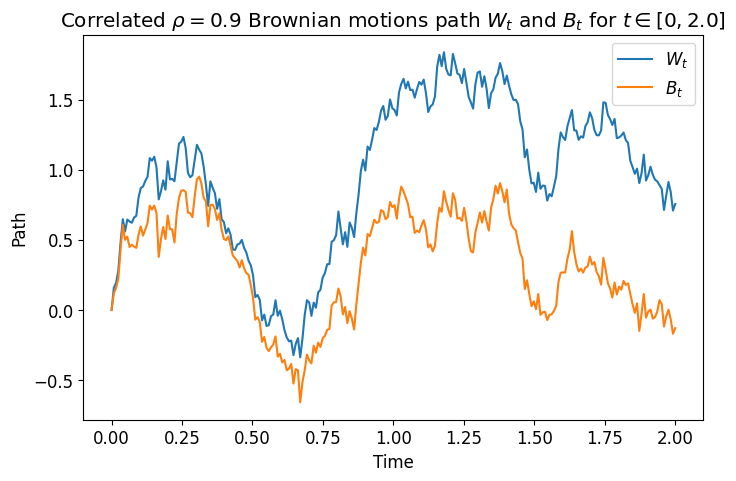

In [51]:
plt.plot(time,W,label="$W_t$")
plt.plot(time,B,label="$B_t$")
plt.title(f"Correlated $\\rho={rho}$ Brownian motions path $W_t$ and $B_t$ for $t\\in [0,{T}]$")
plt.xlabel("Time")
plt.ylabel("Path")
plt.legend()
plt.show()

### Monte Carlo method to compute the average value of the maximum of two correlated Brownian motions 
How can we compute $\mathbb{E}\left[\max\left(\displaystyle\max_{t\in[0,T]} W_t,\displaystyle\max_{t\in[0,T]} B_t\right)\right]$

Same story as before, by using the Central Limit Theorem and the Law of large numbers we can estimate these values, by averaging over multiple trayectories.

This means we can approximate

$$\mathbb{E}\left[\max\left(\displaystyle\max_{t\in[0,T]} W_t,\displaystyle\max_{t\in[0,T]} B_t\right)\right]\approx \frac{1}{M}  \sum_{j=1}^M \max\left(\displaystyle \max_{i=1,...,N} W^j_{t_i} ,\displaystyle \max_{i=1,...,N} B^j_{t_i} \right)$$

In [53]:
np.random.seed(0)
N=252
M=1000
W=np.zeros((N,M))
B=np.zeros((N,M))
T=5.0
time=np.linspace(0,T,N)
Z=np.random.normal(0,np.sqrt(T/(N-1)),size=(N-1,M))
Y=np.random.normal(0,np.sqrt(T/(N-1)),size=(N-1,M))
W[1:,:]=np.cumsum(Z,axis=0)
B[1:,:]=np.cumsum(rho*Z+np.sqrt(1-rho**2)*Y,axis=0)

In [55]:
np.mean(np.maximum(np.max(W,axis=0),np.max(B,axis=0)))

np.float64(1.9714404550026474)

### These are the basics for simulation based pricing!

In the Black-Scholes model a Stock is modelled as $S_t=S_0 e^{\sigma W_t-\frac{\sigma^2 t}{2}}$, so it is straightforward to transform $W$ into $S$ i.e.

In [64]:
S=S0*np.exp(sigma*W-0.5*sigma**2*time.reshape(-1,1))

In [57]:
S0=1.0
sigma=0.2
S=S0*np.exp(sigma*W-0.5*sigma**2*time.reshape(-1,1))

## Fair Warning: 
Note here the need to reshape time, this is because the shape of a 1d array is (N,) which is different from a column vector with dimension (N,1)

In [154]:
print(f"Shape/Dimensionality of time array is: {time.shape}")
print(f"Shape/Dimensionality of reshaped time array is: {time.reshape(-1,1).shape}")

Shape/Dimensionality of time array is: (252,)
Shape/Dimensionality of reshaped time array is: (252, 1)


In [155]:
W-time

ValueError: operands could not be broadcast together with shapes (252,1000) (252,) 

In [156]:
W-time.reshape(-1,1)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.28562406e-01,  3.64454425e-02,  1.17943777e-01, ...,
        -6.65248150e-03, -1.81571698e-01, -7.03639245e-02],
       [ 2.86954458e-01,  1.42238141e-01,  3.85365961e-02, ...,
        -4.25596027e-03, -3.62339157e-01, -2.74946274e-01],
       ...,
       [-6.64768012e+00, -6.43853491e+00, -4.74776103e+00, ...,
        -3.00834321e+00, -4.35535944e+00, -6.41183962e+00],
       [-6.84108651e+00, -6.53060538e+00, -4.75005842e+00, ...,
        -3.10263707e+00, -4.46804582e+00, -6.51023466e+00],
       [-7.01186446e+00, -6.61952104e+00, -4.90428322e+00, ...,
        -3.18942366e+00, -4.48639201e+00, -6.62809613e+00]],
      shape=(252, 1000))